#### Import libraries

In [1]:
import os 
#import time
import xarray as xr 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm 

from sklearn.metrics import r2_score, mean_squared_error

from tqdm import tqdm 

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import cartopy.feature as cf

import torch

from matplotlib.backends.backend_pdf import PdfPages

#### Load input data

In [2]:
epoch = 181
mode = 'val'  # 'train', 'val', 'test'
model = 'Full_Images_200_epochs_Charbonier'

path_dir_input = os.path.join(os.getcwd(), '..', 'data', 'ERA5', 'preprocessed_separate', 'smaller_dataset', mode)
path_dir_target = os.path.join(os.getcwd(), '..', 'data', 'CERRA', 'preprocessed_separate', 'smaller_dataset', mode)

path_dir_output = os.path.join(os.getcwd(), '..', 'AirPollution_Run', model, 'output', 'data', 'valid')

print('Loading input data')
ds_input = xr.open_dataset(os.path.join(path_dir_input, f'{mode}_input_data_cams_global_daily_avg.nc'))
ds_target = xr.open_dataset(os.path.join(path_dir_target, f'{mode}_target_data_cams_europe_regional_daily_avg.nc'))
ds_output = xr.open_dataset(os.path.join(path_dir_output, f'reconstructed_y_hat_s_{epoch:04d}.nc'))

Loading input data


In [3]:
ds_input = ds_input.sortby('time')
ds_target = ds_target.sortby('time')
ds_output = ds_output.sortby('time')

In [4]:
ds_target

<xarray.Dataset>
Dimensions:     (time: 130, latitude: 420, longitude: 700)
Coordinates:
  * latitude    (latitude) float32 71.95 71.85 71.75 71.65 ... 30.25 30.15 30.05
    level       float32 ...
  * time        (time) datetime64[ns] 2023-01-03 2023-01-08 ... 2025-05-18
  * longitude   (longitude) float32 -24.95 -24.85 -24.75 ... 44.75 44.85 44.95
Data variables:
    pm2p5_conc  (time, latitude, longitude) float32 ...
Attributes:
    title:        PM25 Air Pollutant FORECAST at the Surface
    institution:  Data produced by Meteo France
    source:       Data from ENSEMBLE model
    history:      Model ENSEMBLE FORECAST
    FORECAST:     Europe, 20240101-20241231+[0H_21H]
    summary:      ENSEMBLE model hourly FORECAST of PM25 concentration at the...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

In [5]:
i = 100
print(ds_input.time[100].values)
print(ds_target.time[100].values)
print(ds_output.time[100].values)

2024-11-07T00:00:00.000000000
2024-11-07T00:00:00.000000000
2024-11-07T00:00:00.000000000


In [6]:
ds_input

<xarray.Dataset>
Dimensions:    (time: 130, latitude: 106, longitude: 176)
Coordinates:
  * time       (time) datetime64[ns] 2023-01-03 2023-01-08 ... 2025-05-18
  * latitude   (latitude) float64 72.0 71.6 71.2 70.8 ... 31.2 30.8 30.4 30.0
  * longitude  (longitude) float64 -25.0 -24.6 -24.2 -23.8 ... 44.2 44.6 45.0
Data variables:
    pm2p5      (time, latitude, longitude) float32 ...
    blh        (time, latitude, longitude) float32 ...
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    d2m        (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-17T05:16 GRIB to CDM+CF via cfgrib-0.9.1...

In [7]:
ds_target

<xarray.Dataset>
Dimensions:     (time: 130, latitude: 420, longitude: 700)
Coordinates:
  * latitude    (latitude) float32 71.95 71.85 71.75 71.65 ... 30.25 30.15 30.05
    level       float32 ...
  * time        (time) datetime64[ns] 2023-01-03 2023-01-08 ... 2025-05-18
  * longitude   (longitude) float32 -24.95 -24.85 -24.75 ... 44.75 44.85 44.95
Data variables:
    pm2p5_conc  (time, latitude, longitude) float32 ...
Attributes:
    title:        PM25 Air Pollutant FORECAST at the Surface
    institution:  Data produced by Meteo France
    source:       Data from ENSEMBLE model
    history:      Model ENSEMBLE FORECAST
    FORECAST:     Europe, 20240101-20241231+[0H_21H]
    summary:      ENSEMBLE model hourly FORECAST of PM25 concentration at the...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

In [8]:
ds_output

<xarray.Dataset>
Dimensions:     (time: 130, latitude: 420, longitude: 700)
Coordinates:
    level       float32 ...
  * time        (time) datetime64[ns] 2023-01-03 2023-01-08 ... 2025-05-18
  * latitude    (latitude) float32 71.95 71.85 71.75 71.65 ... 30.25 30.15 30.05
  * longitude   (longitude) float32 -24.95 -24.85 -24.75 ... 44.75 44.85 44.95
Data variables:
    pm2p5_conc  (time, latitude, longitude) float32 ...

#### Load DataArrays

In [9]:
ds_input = ds_input["pm2p5"] * 1e9
ds_target = ds_target["pm2p5_conc"]
ds_output = ds_output["pm2p5_conc"]

In [10]:
preds = ds_output.values.flatten()
targets = ds_target.values.flatten()

r2 = r2_score(targets, preds)
mse = mean_squared_error(targets, preds)
rmse = np.sqrt(mse)

print()
print(f"R2: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print()


R2: 0.8557
RMSE: 2.3287



#### Visual Checking

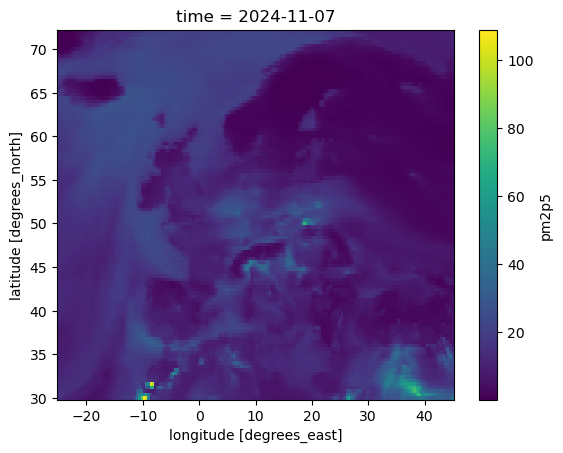

In [11]:
ds_input.isel(time=100).plot()

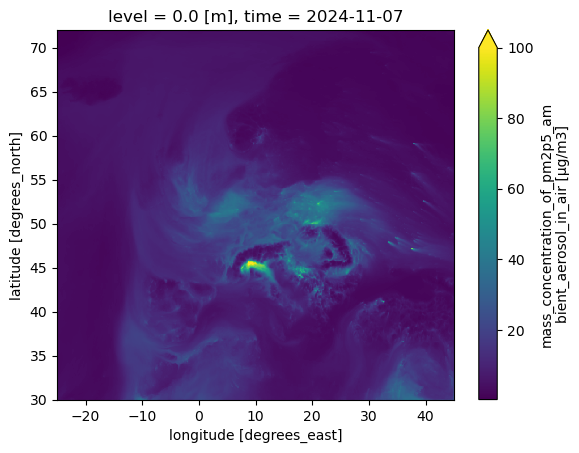

In [12]:
ds_target.isel(time=100).plot(vmax=100)

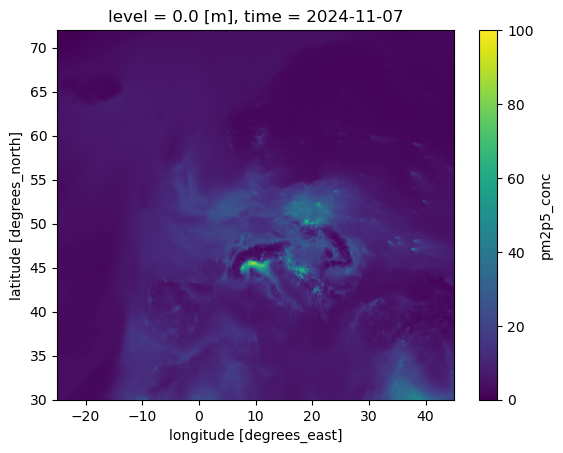

In [13]:
ds_output.isel(time=100).plot(vmin=0, vmax=100)

#### Tranform to numpy arrays

In [14]:
ds_input_np = np.array(ds_input)
ds_target_np = np.array(ds_target)
ds_output_np = np.array(ds_output)

In [15]:
print(ds_input_np.shape)
print(ds_target_np.shape)
print(ds_output_np.shape)

(130, 106, 176)
(130, 420, 700)
(130, 420, 700)


#### Open a PDF file

In [16]:
path_out = os.path.join(os.getcwd())
pdf = PdfPages(os.path.join(path_out, '..', 'IN_OUT_data_ERA5.pdf'))

#### Check individual data

In [17]:
def plot_example_frame(data, indx, save_as, coords=None):
    plt.style.use('default')
    
    fig = plt.figure(figsize=(10, 5))
    
    cmap = 'viridis'
    
    #central_lon, central_lat = -2.6, 38.7
    #extent = [-9.8, 4.5, 31.6, 45.9]
    extent = [data.longitude.min(), data.longitude.max(), data.latitude.min(), data.latitude.max()]

    #coords = list(((-8, 43), (-3.8, 40), (-0.6, 39.6)))
    if coords is None:
        coords = list(((-24.95001220703125, 30.049999237060547), (9.999994277954102, 50.99999809265137), (44.95000076293945, 71.94999694824219)))
    
    #ax = fig.add_subplot(3,2,(2,6), projection=ccrs.Orthographic(central_lon, central_lat))
    ax = fig.add_subplot(3,2,(2,6), projection=ccrs.Mercator())
    
    ax.set_extent(extent)
    gls = ax.gridlines(alpha=0.5, draw_labels=True, dms=True)
    gls.right_labels = False
    gls.top_labels = False
    ax.coastlines(resolution='10m')

    for i, coord in enumerate(coords):
        ax.plot(coord[0], coord[1], 's', color='black', markerfacecolor='white',markersize=7, transform=ccrs.PlateCarree())
        
    vmin, vmax = 0, 70#data.isel(time=indx).max()    
    #im0 = ax.imshow(data.isel(time=indx), cmap=cmap, interpolation='lanczos', vmin=vmin, vmax=vmax, extent=extent, transform=ccrs.PlateCarree())
    im0 = ax.pcolormesh(data.longitude, data.latitude, data.isel(time=indx).values, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    cbar0 = plt.colorbar(im0,ax=ax,fraction=0.046, pad=0.04)
    cbar0.set_label(label=r'Wind speed [ms$^{-1}$]',size=14, labelpad=10)
    ax.set_title(data['time'][indx].dt.date.values) 

    for i, coord in enumerate(coords):
    
        ax = fig.add_subplot(3,2,1 + 2*i)
        ax.plot(data.sel(longitude=coord[0], latitude=coord[1], method='nearest'), linewidth=0.9)
        ax.axhline(data.sel(longitude=coord[0], latitude=coord[1], method='nearest').mean(),ls='--',color='red', linewidth=0.9)
        #ax.get_xaxis().set_visible(False)
        #ymin, ymax = ax.get_ylim()
        #ax.set_yticks(np.arange(0, ymax, 2.5))
        #ax.set_xticks(np.linspace(0,365,12))
        #ax.set_xticklabels(np.arange(0,12))
        #ax.set_xticklabels(['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
        #ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
        ax.get_xaxis().set_visible(True)
            
    plt.tight_layout() 
    pdf.savefig()
    
    if save_as!=None: 
        plt.savefig(save_as)
    plt.show()
    plt.close()
    return

In [18]:
# Extraemos los arrays de latitud y longitud
lons = ds_target.longitude.values
lats = ds_target.latitude.values

# Seleccionamos tres valores representativos cerca del centro del dominio
lon1 = lons[len(lons) // 3]
lon2 = lons[len(lons) // 2]
lon3 = lons[2 * len(lons) // 3]

lat1 = lats[len(lats) // 3]
lat2 = lats[len(lats) // 2]
lat3 = lats[2 * len(lats) // 3]

# Creamos coordenadas como (lon, lat)
coords = [
    (lon1, lat1),
    (lon2, lat2),
    (lon3, lat3)
]

print(coords)


[(-1.6499939, 57.95), (10.05, 50.95), (21.65, 43.95)]


2023
21
2023-04-12T00:00:00.000000000


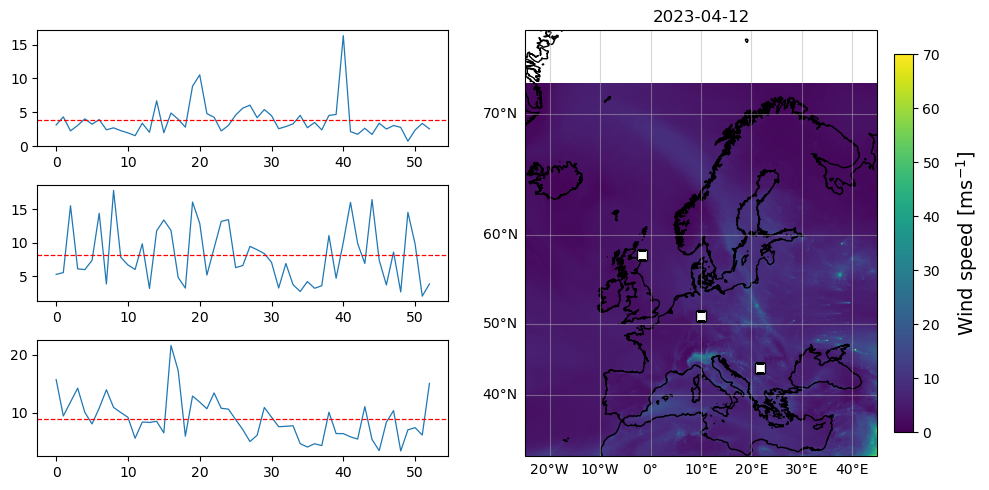

In [19]:
years = ds_target['time'].dt.year
num_years = len(np.unique(years))

year = np.random.randint(num_years)

time = np.random.randint(ds_target.sel(time=ds_target['time'].dt.year == (years[0] + year)).shape[0])

year = 0
time = 21

print((years[0] + year).item())
print(time)
print(ds_target.sel(time=ds_target['time'].dt.year == (years[0] + year)).time[time].values)


plot_example_frame(ds_target.sel(time=ds_target['time'].dt.year == (years[0] + year)), time, save_as=None, coords=coords)

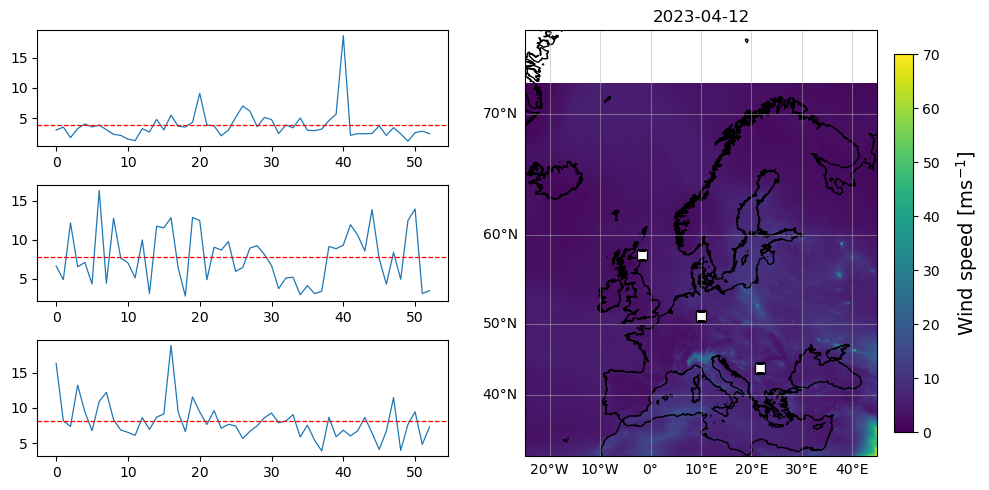

In [20]:
plot_example_frame(ds_output.sel(time=ds_output['time'].dt.year == (years[0] + year)), time, save_as=None, coords=coords)

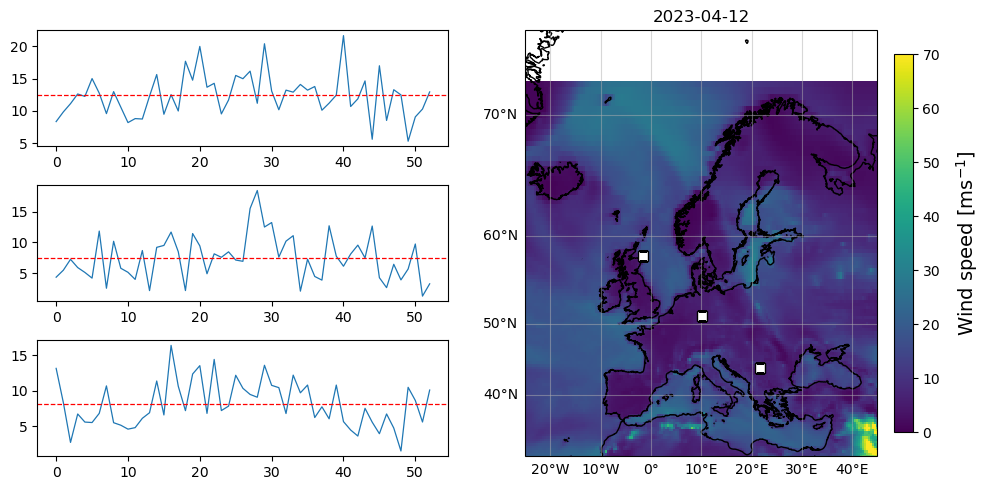

In [21]:
plot_example_frame(ds_input.sel(time=ds_input['time'].dt.year == (years[0] + year)), time, save_as=None, coords=coords)

#### Same plot but with input and output data 

In [30]:
def plot_example_frame_diff_3_plots(data_in, data_tar, data_out, indx, save_as, coords=None):
    plt.style.use('default')
    
    fig = plt.figure(figsize=(10, 5))
    
    cmap = 'viridis'

    locations = ['1', '2', '3']
    
    #central_lon, central_lat = -2.6, 38.7
    #extent = [-9.8, 4.5, 31.6, 45.9]
    #extent = [data_tar.longitude.min(), data_tar.longitude.max(), data_tar.latitude.min(), data_tar.latitude.max()]
    extent = [data_tar.longitude.min(), data_tar.longitude.max(), data_tar.latitude.min(), data_tar.latitude.max()]

    #coords = list(((-8, 43), (-3.8, 40), (-0.6, 39.6)))
    if coords is None:
        coords = list(((-24.95001220703125, 30.049999237060547), (9.999994277954102, 50.99999809265137), (44.95000076293945, 71.94999694824219)))
    
    #ax = fig.add_subplot(3,2,(2,6), projection=ccrs.Orthographic(central_lon, central_lat))
    ax = fig.add_subplot(3,2,(2,6), projection=ccrs.Mercator())
    
    #ax.set_extent(extent)
    gls = ax.gridlines(alpha=0.5, draw_labels=True, dms=True)
    gls.right_labels = False
    gls.top_labels = False
    ax.coastlines(resolution='10m', color='white')
    
    for i, coord in enumerate(coords):
        ax.plot(coord[0], coord[1], 's', color='black', markerfacecolor='white',markersize=7, transform=ccrs.PlateCarree())
        ax.text(coord[0] + 0.15, coord[1], locations[i], fontsize=12, color='white', transform=ccrs.PlateCarree())

    data = data_out - data_tar
    #data = data_out
        
    vmin, vmax = 0, data.isel(time=indx).max()    
    #im0 = ax.imshow(data.isel(time=indx), cmap=cmap, interpolation='lanczos', vmin=vmin, vmax=vmax, extent=extent, transform=ccrs.PlateCarree())
    im0 = ax.pcolormesh(data.longitude, data.latitude, data.isel(time=indx).values, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    cbar0 = plt.colorbar(im0,ax=ax,fraction=0.046, pad=0.04)
    cbar0.set_label(label=r'PM 2.5 [µg/m³]',size=14, labelpad=10)
    #im0.set_clim(vmin=vmin, vmax=vmax)
    ax.set_title('Difference PM 2.5 [µg/m³] [{}]'.format(data['time'][indx].dt.date.values))
    
    for i, coord in enumerate(coords):
        ax = fig.add_subplot(3,2,1 + 2*i)
        ax.plot(data_in.sel(longitude=coord[0], latitude=coord[1], method='nearest'), linewidth=0.9, color='orange', label='Input')
        ax.axhline(data_in.sel(longitude=coord[0], latitude=coord[1], method='nearest').mean(),ls='--',color='orange', linewidth=0.9)
        ax.plot(data_tar.sel(longitude=coord[0], latitude=coord[1], method='nearest'), linewidth=0.9, color='red', label='Target')
        ax.axhline(data_tar.sel(longitude=coord[0], latitude=coord[1], method='nearest').mean(),ls='--',color='red', linewidth=0.9)
        ax.plot(data_out.sel(longitude=coord[0], latitude=coord[1], method='nearest'), linewidth=0.9, color='blue', label='Output')
        ax.axhline(data_out.sel(longitude=coord[0], latitude=coord[1], method='nearest').mean(),ls='--',color='blue', linewidth=0.9)
        #ax.get_xaxis().set_visible(False)
        #ymin, ymax = ax.get_ylim()
        #ax.set_yticks(np.arange(0, 20, 2.5))
        #ax.set_xticks(np.linspace(0,365*24,12))
        #ax.set_xticklabels(np.arange(0,12))
        #ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
        #ax.set_xticklabels(['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
        ax.get_xaxis().set_visible(True)
        ax.text(0.05, 0.95, locations[i], transform=ax.transAxes, fontsize=12, color='black', verticalalignment='top', horizontalalignment='left')

        ax.legend(loc='upper center')
            
    plt.tight_layout() 

    pdf.savefig()
    
    if save_as!=None: 
        print('saving...')
        plt.savefig(save_as)
    plt.show()
    plt.close()
    return

2023
6


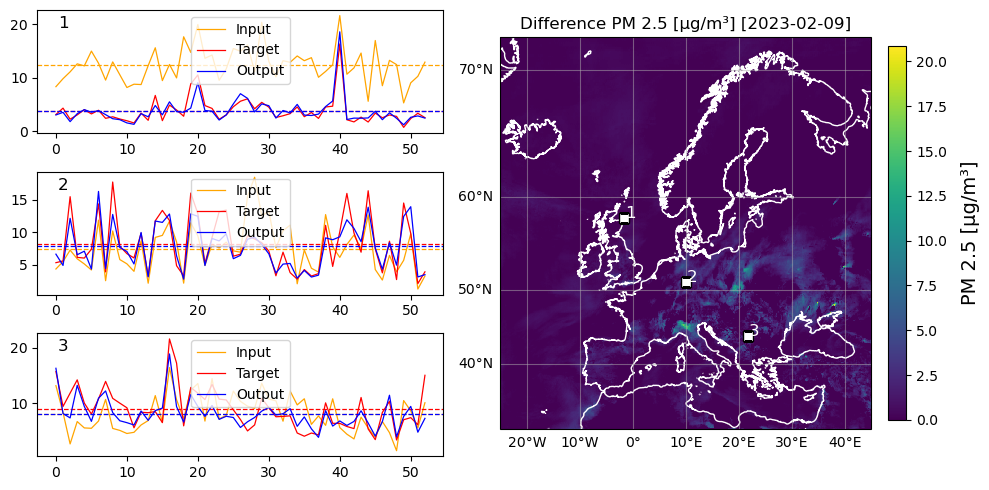

In [31]:
years = ds_target['time'].dt.year
num_years = len(np.unique(years))

year = np.random.randint(num_years)

time = np.random.randint(ds_target.sel(time=ds_target['time'].dt.year == (years[0] + year)).shape[0])

print((years[0] + year).item())
print(time)


plot_example_frame_diff_3_plots(ds_input.sel(time=ds_input['time'].dt.year == (years[0] + year)), ds_target.sel(time=ds_target['time'].dt.year == (years[0] + year)), ds_output.sel(time=ds_output['time'].dt.year == (years[0] + year)), time, save_as=None, coords=coords)

#### Check differences

In [32]:
def Corr_RMSE(data1, data2, time, spain_mask=None): 

    assert data1.shape == data2.shape, "The prediction and target dimensions are different"

    # I take the one temporal frame and flate the wind speed map
    data1_i = np.array(data1[time]).flatten()
    data2_i = np.array(data2[time]).flatten()

    if spain_mask == None:
        mask = ~np.isnan(data1_i) & ~np.isnan(data2_i)
    else:
        mask = ~np.isnan(spain_mask.flatten())

    data1_i = data1_i[mask]
    data2_i = data2_i[mask]

    corr_pixel_space = np.corrcoef(data1_i, data2_i)[0, 1]
    rmse_pixel_space = np.sqrt(np.mean(np.power((data1_i - data2_i), 2)))

    results = {'Corr': corr_pixel_space, 'RMSE': rmse_pixel_space}

    return results

In [33]:
def Corr_RMSE_KGE_NSE(data1, data2, time, spain_mask=None): 
    """
    This funcion calculates the correlación (r), RMSE and Kling-Gupta Efficiency (KGE) of two spatial maps.
    data1: 2D array of map 1.
    data2: 2D array of map 2.
    """

    assert data1.shape == data2.shape, "The prediction and target dimensions are different"

    # Evitar cálculos para series vacías o constantes
    if len(data1) < 2 or np.std(data1) == 0:
        results = {'Corr': np.nan, 'RMSE': np.nan, 'KGE': np.nan}
        return results

    # I take the one temporal frame and flate the wind speed map
    data1_i = np.array(data1[time]).flatten()
    data2_i = np.array(data2[time]).flatten()

    if spain_mask == None:
        mask = ~np.isnan(data1_i) & ~np.isnan(data2_i)
    else:
        mask = ~np.isnan(spain_mask.flatten())

    data1_i = data1_i[mask]
    data2_i = data2_i[mask]

    data1_i_mean = np.mean(data1_i)
    data2_i_mean = np.mean(data2_i)
    data1_i_std = np.std(data1_i)
    data2_i_std = np.std(data2_i)

    corr_pixel_space = np.corrcoef(data1_i, data2_i)[0, 1]
    rmse_pixel_space = np.sqrt(np.mean(np.power((data1_i - data2_i), 2)))

    beta = data1_i_mean / data2_i_mean if data2_i_mean != 0 else np.nan
    gamma = (data1_i_std / data1_i_mean) / (data2_i_std / data2_i_mean) if data2_i_mean != 0 else np.nan
    
    kge = 1 - np.sqrt((corr_pixel_space - 1)**2 + (beta - 1)**2 + (gamma - 1)**2)

    numerator = np.sum((data1_i - data2_i) ** 2)
    denominator = np.sum((data1_i - data1_i_mean) ** 2)
    denominator = np.where(denominator == 0, np.nan, denominator)

    nse = 1 - (numerator / denominator)

    results = {'Corr': corr_pixel_space, 'RMSE': rmse_pixel_space, 'KGE': kge.item(), 'NSE': nse}

    return results

In [45]:
def plot_comparison(data1, data2, time, title):
    plt.style.use('default')
        
    #cmap = 'jet'
    cmap = 'viridis'

    #central_lon, central_lat = 11, 48
    #extent = [-10.3, 5, 31, 46.4]
    extent = [data1.longitude.min(), data1.longitude.max(), data1.latitude.min(), data1.latitude.max()]

    timestamp = pd.Timestamp(data1.coords["time"][time].values)
    formatted_time_1 = timestamp.strftime('%Y-%m-%dT%H:%M')

    timestamp = pd.Timestamp(data2.coords["time"][time].values)
    formatted_time_2 = timestamp.strftime('%Y-%m-%dT%H:%M')

    fig, axs = plt.subplots(nrows=1,ncols=2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(16,8))

    axs=axs.flatten()

    for i in range(2):
        #ax = plt.axes(projection=ccrs.Orthographic(central_lon, central_lat))

        axs[i].set_extent(extent)
        #axs[i].gridlines(alpha=0.8)
        #gls = axs[i].gridlines(alpha=0.5, draw_labels=True, dms=True)
        #gls.right_labels = False
        #gls.top_labels = False
        axs[i].coastlines(resolution='10m')
    
    vmin, vmax = 0, 80#data1.isel(time=time).max()
    #im0 = axs[0].imshow(data1.isel(time=time), cmap=cmap, interpolation='lanczos', vmin=vmin, vmax=vmax, extent=extent, transform=ccrs.PlateCarree())
    im0 = axs[0].pcolormesh(data1.longitude, data1.latitude, data1.isel(time=time).values, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    cbar0 = plt.colorbar(im0,ax=axs[0],fraction=0.046, pad=0.04)
    cbar0.set_label(label=r'Wind speed [ms$^{-1}$]',size=14, labelpad=10)
    axs[0].set_title('{} ({})'.format(title, formatted_time_1)) #Ground True
    
    if vmin==vmax:
        cbar0.set_ticks([0])
    
    #vmin, vmax = 0, data.isel(time=time).max()
    #im1 = axs[1].imshow(data2.isel(time=time), cmap=cmap, interpolation='lanczos', vmin=vmin, vmax=vmax, extent=extent, transform=ccrs.PlateCarree())
    im1 = axs[1].pcolormesh(data2.longitude, data2.latitude, data2.isel(time=time).values, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    cbar1 = plt.colorbar(im1,ax=axs[1],fraction=0.046, pad=0.04)
    cbar1.set_label(label=r'Wind speed [ms$^{-1}$]',size=14, labelpad=10)
    axs[1].set_title('Output ({})'.format(formatted_time_2))

    if vmin==vmax:
        cbar1.set_ticks([1])

    # Add a general title to the figure
    fig.suptitle('Visual Comparison', fontsize=16)

    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    fig.subplots_adjust(top=1)

    pdf.savefig()
    
    plt.show()
    plt.close()
    return

In [46]:
time = np.random.randint(ds_target.shape[0])
print(ds_target.time[time].values)

2024-06-27T00:00:00.000000000


2024-06-27T00:00:00.000000000
2024-06-27T00:00:00.000000000

Corr:  0.956765
RMSE:  2.079686
KGE:  0.874059
NSE:  0.904766


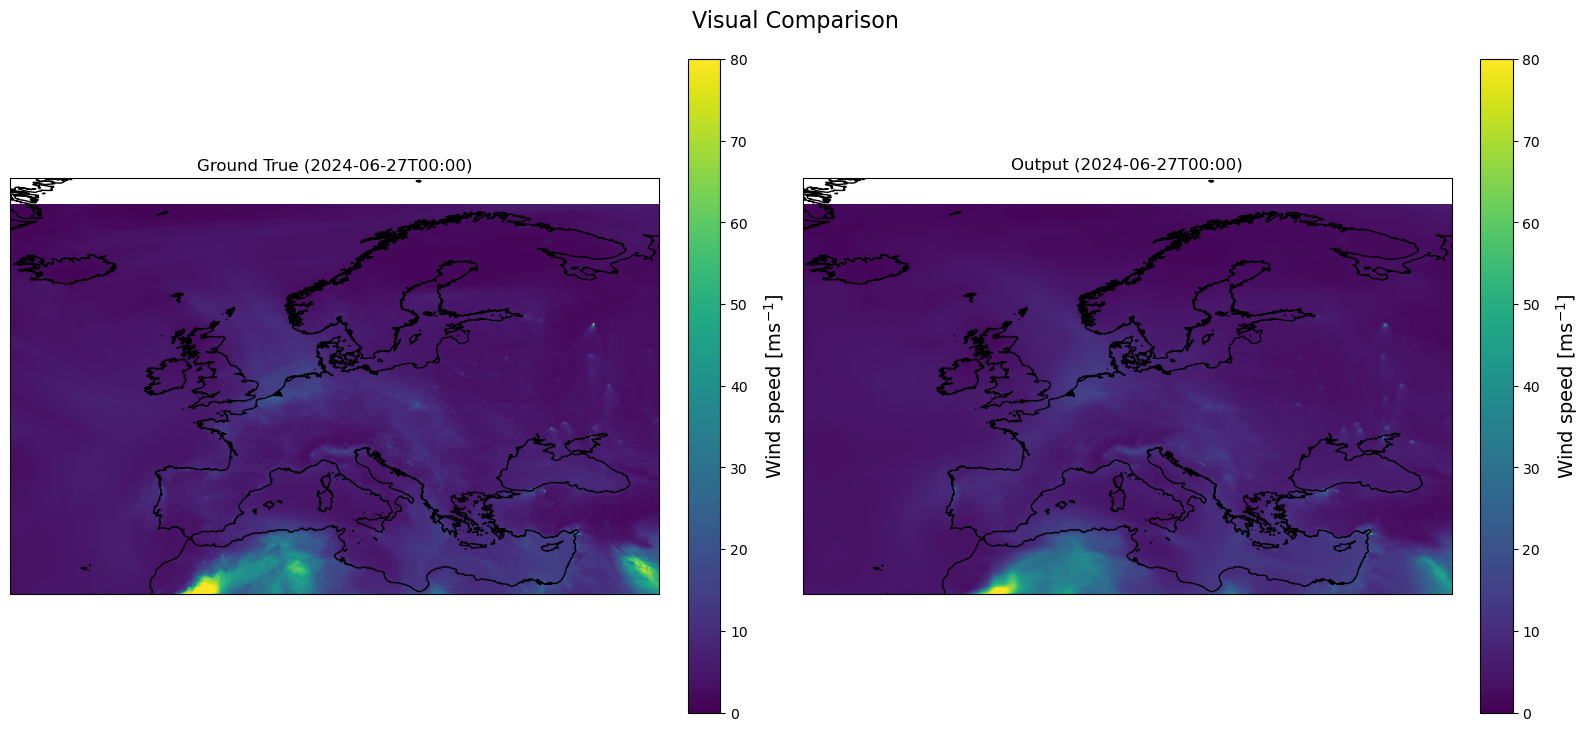

In [47]:
print(ds_target.coords["time"][time].values)
print(ds_output.coords["time"][time].values)
print()
results = Corr_RMSE_KGE_NSE(data1=ds_target, data2=ds_output, time=time)
print('Corr: ', np.round(results["Corr"], 6))
print('RMSE: ',  np.round(results["RMSE"], 6))
print('KGE: ',  np.round(results["KGE"], 6))
print('NSE: ',  np.round(results["NSE"], 6))

plot_comparison(ds_target, ds_output, time, 'Ground True')

#### Correlation

#### Total

#### Training Dataset

In [48]:
times_t = []
corr_t = []
RMSE_t = []

for time in tqdm(range(0, ds_target.shape[0])):
    result = Corr_RMSE(data1=ds_target, data2=ds_output, time=time)
    times_t.append(time)
    corr_t.append(result['Corr'])
    RMSE_t.append(result['RMSE'])

times_t = np.array(times_t)
corr_t = np.array(corr_t)
RMSE_t = np.array(RMSE_t)

100%|██████████| 130/130 [00:03<00:00, 33.96it/s]


In [49]:
print('Train comparison:')
print()
print('Corr')
print('MIN: ', corr_t.min().item())
print('MAX: ', corr_t.max().item())
print('MEAN: ', corr_t.mean().item())
print('STD: ', corr_t.std().item())
print()
print('RMSE')
print('MIN: ', RMSE_t.min().item())
print('MAX: ', RMSE_t.max().item())
print('MEAN: ', RMSE_t.mean().item())
print('STD: ', RMSE_t.std().item())

Train comparison:

Corr
MIN:  0.8183471286635499
MAX:  0.9723555705825466
MEAN:  0.9368184291728867
STD:  0.02061965879519797

RMSE
MIN:  1.1199930906295776
MAX:  9.148362159729004
MEAN:  2.089742660522461
STD:  1.0275964736938477


In [50]:
in_train_target_time_np = np.array(ds_target.time)
print(in_train_target_time_np.shape)

(130,)


In [51]:
min = in_train_target_time_np[-130]
max = in_train_target_time_np[-1]

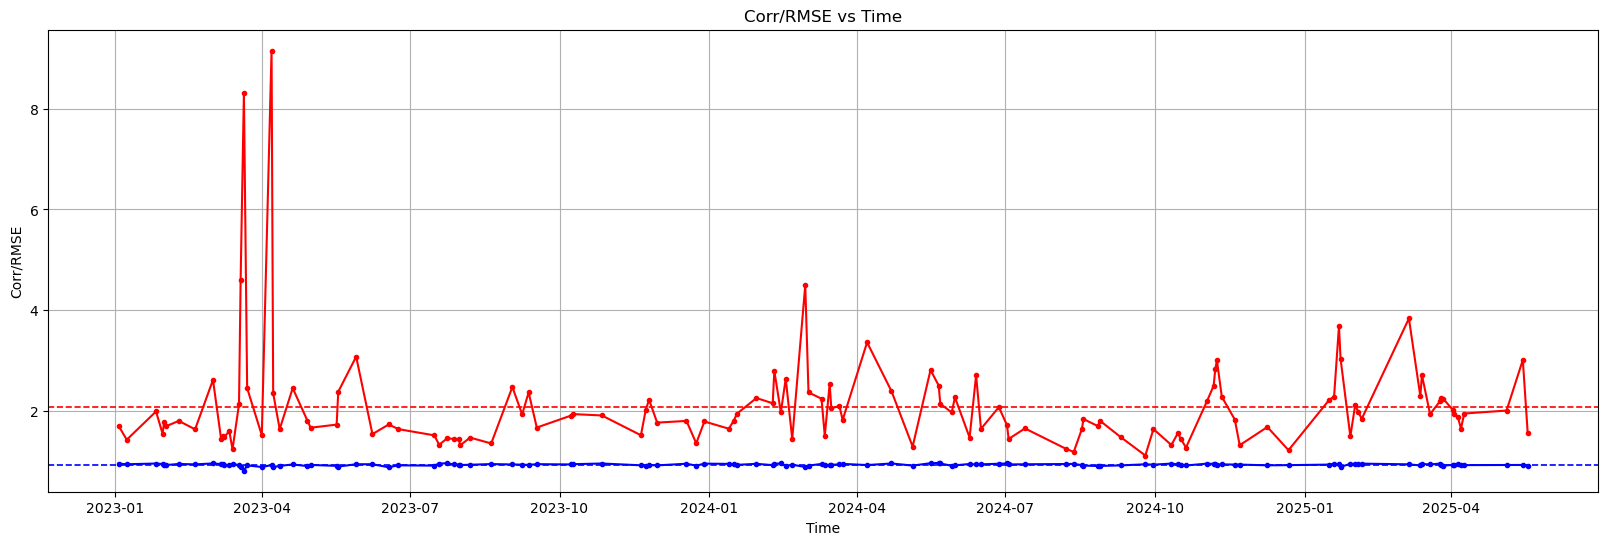

In [52]:
plt.figure(figsize=(20, 6))

plt.plot(in_train_target_time_np, corr_t, marker='.', linestyle='-', color='blue')
plt.plot(in_train_target_time_np, RMSE_t, marker='.', linestyle='-', color='red')

# Líneas de promedio
plt.axhline(np.mean(corr_t), color='blue', linestyle='--', linewidth=1.2, label='Mean Corr')
plt.axhline(np.mean(RMSE_t), color='red', linestyle='--', linewidth=1.2, label='Mean RMSE')

plt.xlabel('Time')
plt.ylabel('Corr/RMSE')
#plt.xlim(min, max)
#plt.ylim(0, 1)
plt.title('Corr/RMSE vs Time')
plt.grid(True)
pdf.savefig()

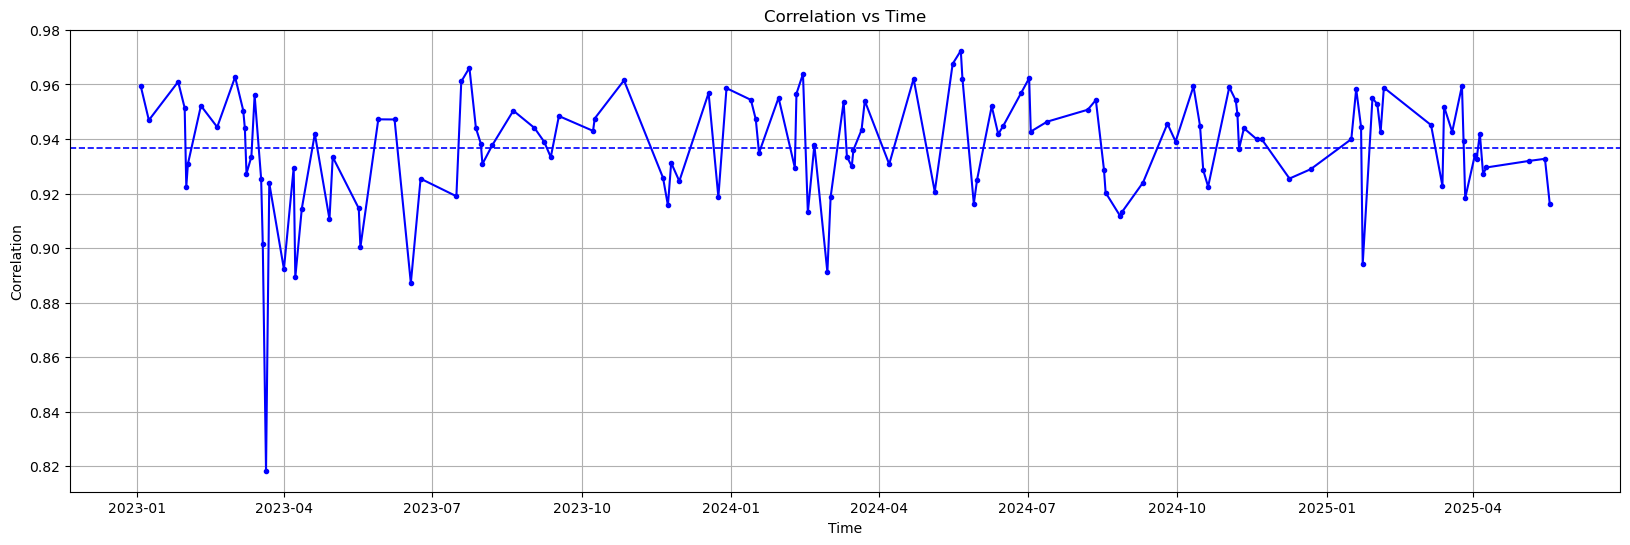

In [53]:
plt.figure(figsize=(20, 6))

plt.plot(in_train_target_time_np, corr_t, marker='.', linestyle='-', color='blue')
#plt.plot(in_train_target_time_np, RMSE, marker='.', linestyle='-', color='red')

# Líneas de promedio
plt.axhline(np.mean(corr_t), color='blue', linestyle='--', linewidth=1.2, label='Mean Corr')
#plt.axhline(np.mean(RMSE_t), color='red', linestyle='--', linewidth=1.2, label='Mean RMSE')

plt.xlabel('Time')
plt.ylabel('Correlation')
#plt.xlim(0, 1000)#in_train_data.shape[0])
#plt.ylim(0, 2)
plt.title('Correlation vs Time')
plt.grid(True)
pdf.savefig()

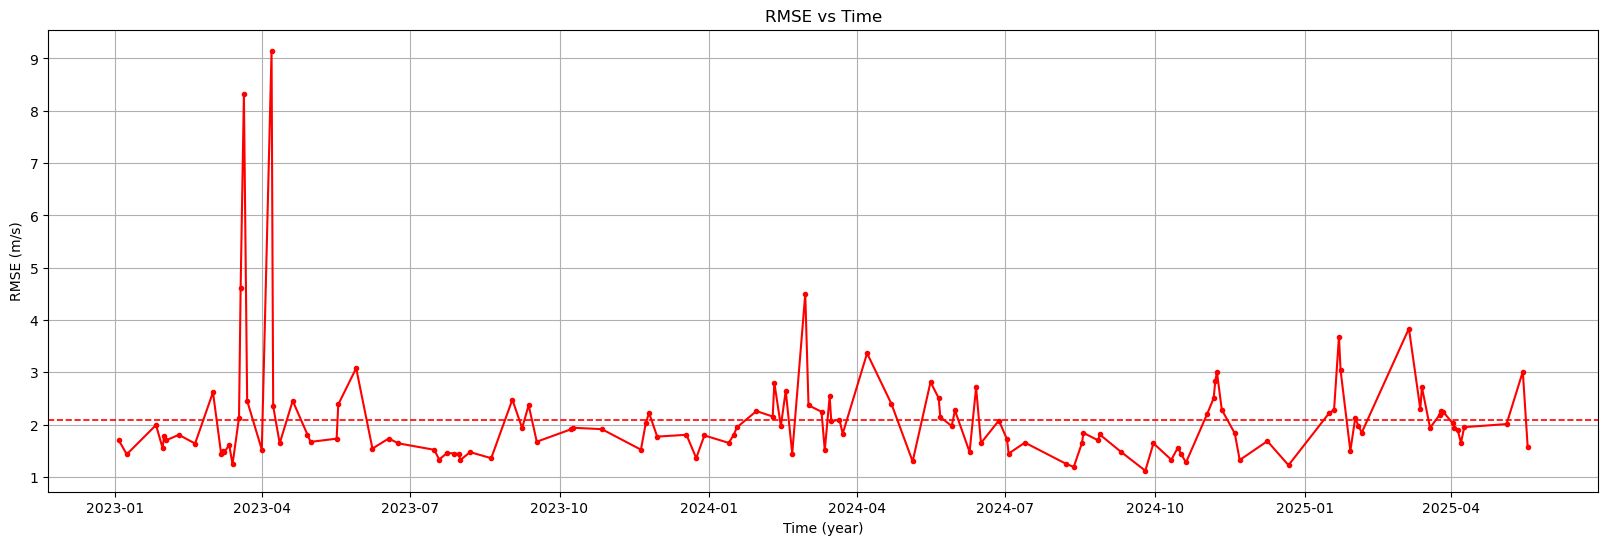

In [54]:
plt.figure(figsize=(20, 6))

#plt.plot(times, corr, marker='.', linestyle='-', color='blue')
plt.plot(in_train_target_time_np, RMSE_t, marker='.', linestyle='-', color='red')

# Líneas de promedio
#plt.axhline(np.mean(corr_t), color='blue', linestyle='--', linewidth=1.2, label='Mean Corr')
plt.axhline(np.mean(RMSE_t), color='red', linestyle='--', linewidth=1.2, label='Mean RMSE')

plt.xlabel('Time (year)')
plt.ylabel('RMSE (m/s)')
#plt.xlim(0, 1000)#in_train_data.shape[0])
#plt.ylim(0, 2)
plt.title('RMSE vs Time')
plt.grid(True)
pdf.savefig()

#### Basic Statistics

#### Training Dataset

In [55]:
print('MIN: ')
print('Input: ', ds_input.min().item())
print('Target: ', ds_target.min().item())
print('Output: ', ds_output.min().item())
print('Rel. difference: ', np.round((abs(ds_output.min() - ds_target.min()) * 100 / ds_target.min()).item(), 3), '%')
print()
print('MAX: ')
print('Input: ', ds_input.max().item())
print('Target: ', ds_target.max().item())
print('Output: ', ds_output.max().item())
print('Rel. difference: ', np.round((abs(ds_output.max() - ds_target.max()) * 100 / ds_target.max()).item(), 3), '%')
print()
print('MEAN: ')
print('Input', ds_input.mean().item())
print('Target', ds_target.mean().item())
print('Output', ds_output.mean().item())
print('Rel. difference: ', np.round((abs(ds_output.mean() - ds_target.mean()) * 100 / ds_target.mean()).item(), 3), '%')
print()
print('STD: ')
print('Input', ds_input.std().item())
print('Target', ds_target.std().item())
print('Output', ds_output.std().item())
print('Rel. difference: ', np.round((abs(ds_output.std() - ds_target.std()) * 100 / ds_target.std()).item(), 3), '%')
print()

MIN: 
Input:  0.0001425809896318242
Target:  0.09018232673406601
Output:  -2.1540427207946777
Rel. difference:  2488.542 %

MAX: 
Input:  894.5433349609375
Target:  343.0235900878906
Output:  140.03492736816406
Rel. difference:  59.176 %

MEAN: 
Input 11.040315628051758
Target 6.169351577758789
Output 6.033237457275391
Rel. difference:  2.206 %

STD: 
Input 8.915671348571777
Target 6.130437850952148
Output 5.42647123336792
Rel. difference:  11.483 %



#### Histograms

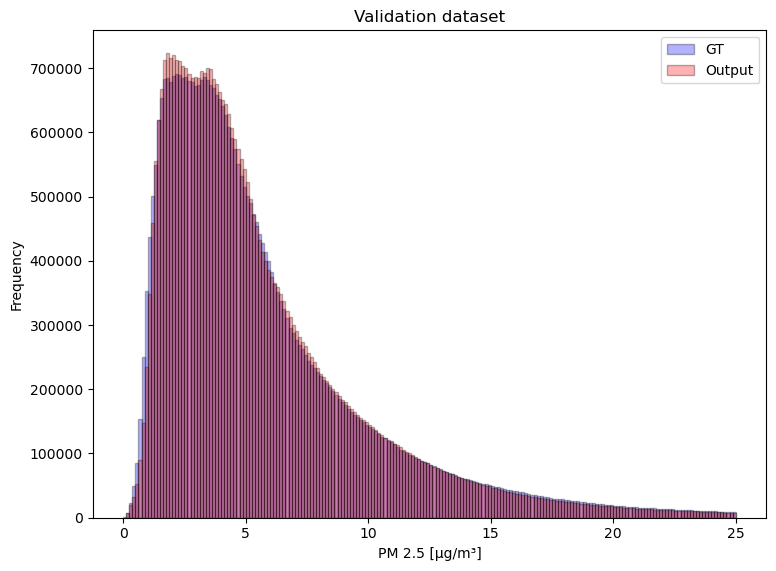

In [56]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
fig.tight_layout(pad=3.0)

axes.hist(ds_target_np.flatten(), bins=200, alpha=0.3, color='blue', label='GT', edgecolor='black', range=(0, 25))
axes.hist(ds_output_np.flatten(), bins=200, alpha=0.3, color='red', label='Output', edgecolor='black', range=(0, 25))
#axes.set_xlim([0, 25])
#axes.set_ylim([0, 0.01])
axes.set_title('Validation dataset')
axes.set_xlabel('PM 2.5 [µg/m³]')
axes.set_ylabel('Frequency')
axes.legend()
pdf.savefig()

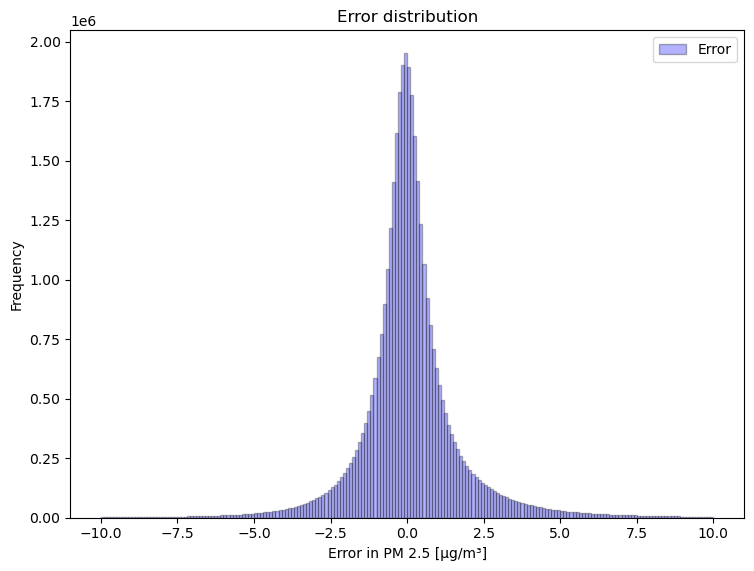

In [69]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
fig.tight_layout(pad=3.0)

axes.hist((ds_target_np.flatten() - ds_output_np.flatten()), bins=200, alpha=0.3, color='blue', label='Error', edgecolor='black', range=(-10, 10))
#axes.hist(ds_output_np.flatten(), bins=200, alpha=0.3, color='red', label='Output', edgecolor='black', range=(0, 25))
#axes.set_xlim([-10, 10])
#axes.set_ylim([0, 0.01])
axes.set_title('Error distribution')
axes.set_xlabel('Error in PM 2.5 [µg/m³]')
axes.set_ylabel('Frequency')
axes.legend()
pdf.savefig()

In [62]:
rel_error = (ds_target_np.flatten() - ds_output_np.flatten())/ ds_target_np.flatten()

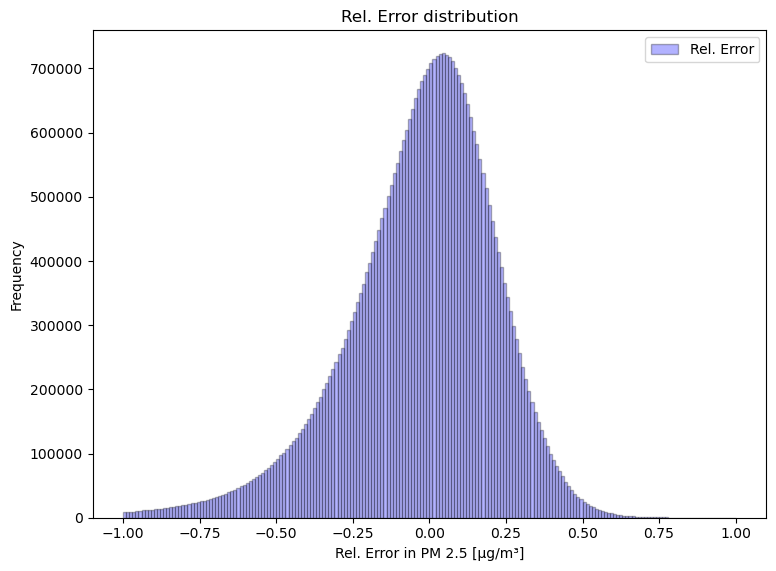

In [70]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
fig.tight_layout(pad=3.0)

axes.hist(rel_error, bins=200, alpha=0.3, color='blue', label='Rel. Error', edgecolor='black', range=(-1, 1))
#axes.hist(ds_output_np.flatten(), bins=200, alpha=0.3, color='red', label='Output', edgecolor='black', range=(0, 25))
#axes.set_xlim([0, 25])
#axes.set_ylim([0, 0.01])
axes.set_title('Rel. Error distribution')
axes.set_xlabel('Rel. Error in PM 2.5 [µg/m³]')
axes.set_ylabel('Frequency')
axes.legend()
pdf.savefig()

In [65]:
print(rel_error.mean())
print(rel_error.std())
print(rel_error.min())
print(rel_error.max())

-0.034968507
0.26212013
-27.081114
2.251944


In [49]:
pdf.close()